# CAM - Class Activation Map Explained

I'm using this notebook to learn more about [CAM](https://arxiv.org/pdf/1512.04150.pdf). I will use a dataset of 512x512 trainset images converted into jpg format to quickly train a simple classifier (resnet18), and then use it to analyse class activation maps.

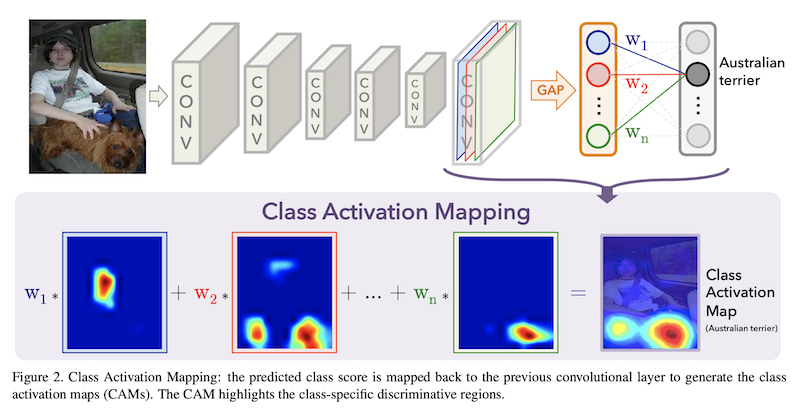

The basic idea is as follows:
- After a series of convolutions, we end up with a small grid and a large number of channels. In our case, starting with 448 image and resnet18, after all the convolutions we end up with a 14x14 grid and 512 channels.
- We can think of the grid as downsampled image and the channels as different features discovered in that image.
- We then average the channels across that grid and multiply them with a set of weights to come up with the final prediction for each class (global average pooling followed by linear layer).
- To understand which region of the image contributed to the final prediction the most, we can apply the weights to each element of the 14x14 grid (before averaging).
- The regions with highest value contributed the most. 
- We can then overlay the activation map with the original image to visualize this. 

This notebook is largely based on chapter 18 in [Deep Learning for Coders with Fastai and PyTorch](https://www.amazon.com/Deep-Learning-Coders-fastai-PyTorch/dp/1492045527).

# Model Training

In [ ]:
!pip install iterative_stratification -q

from fastai.vision.all import *
import numpy as np
import pandas as pd
import torch
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
import warnings
warnings.filterwarnings('ignore')
torch.set_printoptions(precision=3, sci_mode=False)

sample_size = 1
seed = 42
stats = ([0.07237246, 0.04476176, 0.07661699], [0.17179589, 0.10284516, 0.14199627])
item_tfms = RandomResizedCrop(448, min_scale=0.75, ratio=(1.,1.))
batch_tfms = [*aug_transforms(flip_vert=True, max_warp=0), Normalize.from_stats(*stats)]
bs = 32
lr = 3e-2
epochs = 2
cbs = None

df = pd.read_csv('../input/hpa-single-cell-image-classification/train.csv')
path = Path('../input/hpa-512x512-jpg-images-dataset/512x512jpgs')

labels = [str(i) for i in range(19)]
for x in labels: df[x] = df['Label'].apply(lambda r: int(x in r.split('|')))

dfs = df.sample(frac=sample_size, random_state=seed).reset_index(drop=True)
y = dfs[labels].values
X = dfs['ID'].values
dfs['fold'] = np.nan

mskf = MultilabelStratifiedKFold(n_splits=5)
for i, (_, test_index) in enumerate(mskf.split(X, y)):
    dfs.iloc[test_index, -1] = i
   
dfs['fold'] = dfs['fold'].astype('int')
dfs['is_valid'] = False
dfs['is_valid'][dfs.fold == 0] = True

def get_x(r): return path/f'{r["ID"]}.jpg'
def get_y(r): return list(set(r['Label'].split('|')))

dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock(vocab=labels)),
                    splitter=ColSplitter(col='is_valid'),
                    get_x=get_x,
                    get_y=get_y,
                    item_tfms=item_tfms,
                    batch_tfms=batch_tfms
                    )
dls = dblock.dataloaders(dfs, bs=bs)

learn = cnn_learner(dls, resnet18, metrics=[accuracy_multi, APScoreMulti()]).to_fp16()

In [ ]:
learn.fine_tune(epochs, base_lr=lr, cbs=cbs)

# Pytorch Hook: get access to layer activations!

To implement CAM, we need to get access to the activations of the last convolutional layer - we will use Pytorch Hook for this. We use Hook as context manager to avoid leaking memory - for that reason we define `__enter__` and `__exit__` methods. 

In [ ]:
class Hook():
    def __init__(self,m):
        self.hook = m.register_forward_hook(self.hook_func)
    def hook_func(self,m,i,o):
        self.stored = o.detach().clone()
    def __enter__(self, *args): return self
    def __exit__(self, *args):
        self.hook.remove()

For visualization, we will focus on a single image for now. Let's grab one from our validation set and show the image along with the labels. Note that we trained a model with random cropping, and we will apply the same transform here. We will select one with class 12:

### excerpt from hosts' notebook describing cell classes:

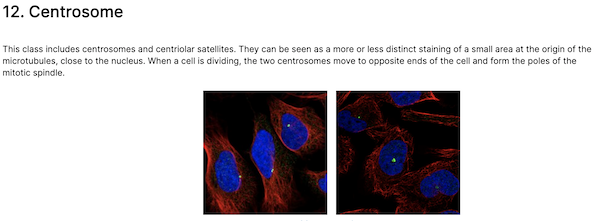

In [ ]:
labelnum = 12
label = str(labelnum)
image_id = '39c61ede-bbbc-11e8-b2ba-ac1f6b6435d0'

sample = dfs[dfs.ID == image_id].reset_index(drop=True)
print(f'ID: {sample.ID.loc[0]}, Label: {sample.Label.loc[0]}')
img = PILImage.create(get_x(sample.loc[0]))
img.show(figsize=(10,10));

fastai models are conveniently splitted after the last convolutional layer. We will need to store the outputs of the first layer group `learn.model[0]` with the hook. Let's confirm that the shape is a 14x14 grid with 512 channels as expected (plus batch size 1 dimension). 

In [ ]:
x, = first(dls.test_dl([img]))
with Hook(learn.model[0]) as hook:
    with torch.no_grad():
        output = learn.model.eval()(x.cuda())
    act = hook.stored
print(act.shape)

Now let's double check the class predictions. It looks good!

In [ ]:
pred = F.sigmoid(output).cpu()
print(pred)
print(f'Class proba: {pred[0][labelnum]}')

Now we use einsum notation to calculate the dot product between our activation grid and the channel weights. The output should be a grid showing activation strength for each of classes that we predict. 

In [ ]:
cam_map = torch.einsum('ck,kij->cij', learn.model[1][-1].weight, act[0])
cam_map.shape

We can now visualize the grid! Let's look at the CAM map for our centrosome class. 

In [ ]:
x_dec = TensorImage(dls.train.decode((x,))[0][0])
_,ax = plt.subplots(figsize=(10,10))
x_dec.show(ctx=ax)
ax.imshow(cam_map[labelnum].detach().cpu(), alpha=0.6, extent=(0,448,448,0), interpolation='bilinear', cmap='magma');

Worked like charm :) How about the other label for this image (0 - nucleoplasm)? 

In [ ]:
x_dec = TensorImage(dls.train.decode((x,))[0][0])
_,ax = plt.subplots(figsize=(10,10))
x_dec.show(ctx=ax)
ax.imshow(cam_map[0].detach().cpu(), alpha=0.7, extent=(0,448,448,0), interpolation='bilinear', cmap='magma');

We now see a stronger activation in the bottom left corner which I think makes sense. 

# End. 